In [1]:
# import ursse.sync_motion_simulation as sms
import pandas as pd
import os 
import numpy as np
from ursse.path_assistant import PathAssistant, shifts_folder
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import pickle
import valstore as vt
from config_ursse import get_from_config, get_path_from_config
images_dir = os.path.join(get_path_from_config("URSSE_sync_motion_note_dir"),
                          "images")
from ursse.utils import normalize, myhist
iota_revolution_period = get_from_config("IOTA_revolution_period")

In [2]:
rf_noise_std_list = 1e-5*np.arange(16)
str_label_list = [f'{x:.1e}' for x in rf_noise_std_list]
spad_tts_list = [0.350, 0.400, 0.450]
spad_tts_dist_list = ['Gamma', 'Gaussian']
tot_n = len(str_label_list) * len(spad_tts_list) * len(spad_tts_dist_list)
with open(os.path.join(shifts_folder, "all_data_sim_cache", "all_results.pkl"), 'rb') as f:
    all_results = pickle.load(f)

In [3]:
best_rf_label = "6.0e-05"
vt.newval("BestRfStd", float(best_rf_label), "{:.1e}", "rad",
          "analyzing_collected_data/all_single_electron_data/plots_for_JINST.ipynb")

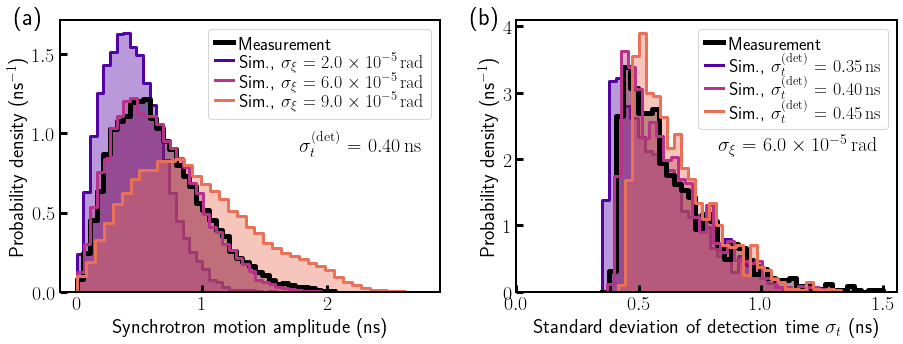

In [18]:
from ursse.path_assistant import get_plot_style_sheet
plt.style.use(get_plot_style_sheet("jinst"))
plt.rc('text.latex', preamble=
       r'\usepackage{siunitx}')
tts_latex = r"$\sigma^{\mathrm{(det)}}_t$"
fit_tts = 0.4
rf_proj = [r for r in all_results if (r['spad_tts'] == fit_tts) and (r['spad_tts_dist'] == 'Gamma')]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
ax0, ax1 = axs

colormap = cm.get_cmap("plasma")
cols = [colormap(i/14) for i in [2,6,9]]
alpha = 0.4
subtitlepos = 0.95, 0.5


for i, res in enumerate([rf_proj[j] for j in [2,6,9]]):
    rf_noise_std = res['rf_noise_std']
    rf_noise_label = res['rf_std_label']
    data = res['data']
    x = data['amplitude']['bin_centers']
    if i == 0:
        col="black"
        y = normalize(data['amplitude']['aggregated_hists']['meas'])/(x[1]-x[0])
        myhist(ax0, x, y, label="Measurement",
                linewidth=5, color=col, zorder=1)
    y = normalize(data['amplitude']['aggregated_hists']['sim'])/(x[1]-x[0])
    col = cols[i]
    myhist(ax0, x, y, label=r"Sim., $\sigma_\xi$ = "+r"\SI{"+rf_noise_label+"}{rad}",
           color=col, zorder=i,
           linewidth=3)
ax0.set_ylabel("Probability density (ns$^{-1}$)")
ax0.set_xlabel("Synchrotron motion amplitude (ns)")
ax0.text(*subtitlepos, tts_latex+r" = $\SI{0.40}{ns}$",
         transform=ax0.transAxes,
         va='bottom', ha='right')
ax0.set_ylim(0, ax0.get_ylim()[1])
ax0.legend()


tts_proj = [r for r in all_results\
                if (r['rf_std_label'] == best_rf_label) and (r['spad_tts_dist'] == 'Gamma')]
for i, res in enumerate(tts_proj):
    tts = res['spad_tts']
    data = res['data']
    x = data['rms_length']['bin_centers']
    if i == 0:
        col="black"
        y = normalize(data['rms_length']['aggregated_hists']['meas'])/(x[1]-x[0])
        myhist(ax1, x, y, 
                label="Measurement",
                linewidth=5, color=col, zorder=1)
    y = normalize(data['rms_length']['aggregated_hists']['sim'])/(x[1]-x[0])
    col = cols[i]
    myhist(ax1, x, y,  label="Sim., "+tts_latex+" = "+r"\SI{" + f"{tts:.2f}" + r"}{ns}",
           color=col, zorder=i,
           linewidth=3)
ax1.set_ylabel("Probability density (ns$^{-1}$)")
ax1.set_xlabel("Standard deviation of detection time $\sigma_t$ (ns)")
ax1.text(*subtitlepos, r"$\sigma_\xi$ = $\SI{6.0e-5}{rad}$",
         transform=ax1.transAxes,
         va='bottom', ha='right')
ax1.set_xlim(0, ax1.get_xlim()[1])
ax1.set_ylim(0, ax1.get_ylim()[1])
ax1.legend()

for ax, lab in zip(axs, ["(a)", "(b)"]):
    ax.text(-0.12, 1.05, lab, transform=ax.transAxes, va='top', ha='left',
           fontsize=24)

fig.savefig(os.path.join(images_dir,
                             "various_rf_jitter_std.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [5]:
vt.newval("ReconstructedSpadTtsHist", 0.4, "{:.2f}", "ns",
          "analyzing_collected_data/all_single_electron_data/plots_for_JINST.ipynb")

In [6]:
from matplotlib import cm
colormap = cm.get_cmap("plasma")
purple = colormap(6/14)

In [7]:
from scipy.optimize import fsolve
gamma = get_from_config("gamma")
alpha = get_from_config("ring_alpha")
V = get_from_config("Vrf")
T0 = get_from_config("IOTA_revolution_period")
f = 1/T0
h = get_from_config("RF_q")
meMeV = get_from_config("me_MeV")
E0 = gamma*meMeV*1e6
eta = alpha - 1/gamma**2
v0 = V / E0
w = 2 * np.pi * h * eta
# phi0 = np.arcsin(Et/V)
rad_to_ns = 1e9/2/np.pi/(h*f)
ws = np.sqrt(w*v0)/T0
Ts = 2*np.pi/ws
Ts

0.00031625029866477045

In [8]:
vt.newval("SyncPerSmallAmpTheor", 1e3*Ts, "{:.3f}", "ms",
          "analyzing_collected_data/all_single_electron_data/plots_for_JINST.ipynb")

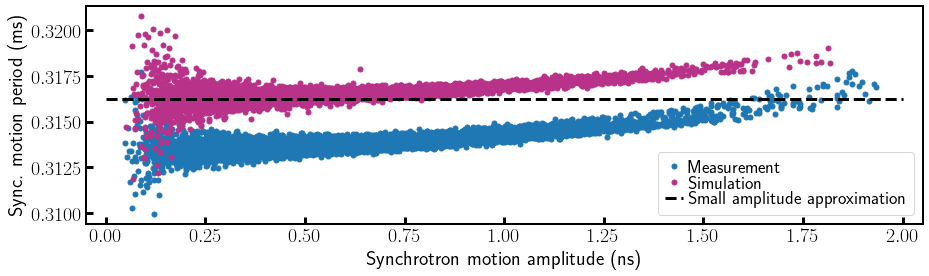

In [9]:
from ursse.path_assistant import get_plot_style_sheet
plt.style.use(get_plot_style_sheet("jinst"))
best_res = [r for r in all_results if\
           (r['rf_std_label'] == "6.0e-05") and (r['spad_tts'] == fit_tts)\
           and (r['spad_tts_dist'] == "Gamma")][0]
d = best_res['data']['amp_per_corr']
meas = d['meas']
sim = d['sim']
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(meas['amps'], 1e3*meas['pers'], '.', label='Measurement')
ax.plot(sim['amps'], 1e3*sim['pers'], '.', color=purple, label='Simulation')
ax.plot(np.array([0,2]),1e3*Ts*np.ones(2), color='black', linestyle='--', label="Small amplitude approximation")
ax.set_xlim(-0.05, 2.05)
ax.set_ylabel("Sync. motion period (ms)")
ax.set_xlabel("Synchrotron motion amplitude (ns)")
ax.legend(loc="lower right")
fig.savefig(os.path.join(images_dir,
                             "correlation_of_amplitude_and_sync_period.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [10]:
per_small_amp = 1e3 * meas[meas['amps'] < 0.25]['pers'].mean()
vt.newval("SyncPerSmallAmp", per_small_amp, "{:.3f}", "ms",
          "analyzing_collected_data/all_single_electron_data/plots_for_JINST.ipynb")
per_iota_rev_num = int(np.round(1e-3*per_small_amp/iota_revolution_period))
vt.newval("SyncPerSmallAmpRevNum", per_iota_rev_num, "{:.0f}", "",
          "analyzing_collected_data/all_single_electron_data/plots_for_JINST.ipynb")

In [11]:
(1e3*Ts-per_small_amp)/per_small_amp

0.008956621408624733

In [12]:
0.5*(1/96.4)

0.005186721991701245

In [13]:
np.sqrt(1-1/gamma**2)

0.9999859505026212

In [14]:
0.055*(1+1/2)/2/(150/0.511)**2

4.787218333333334e-07

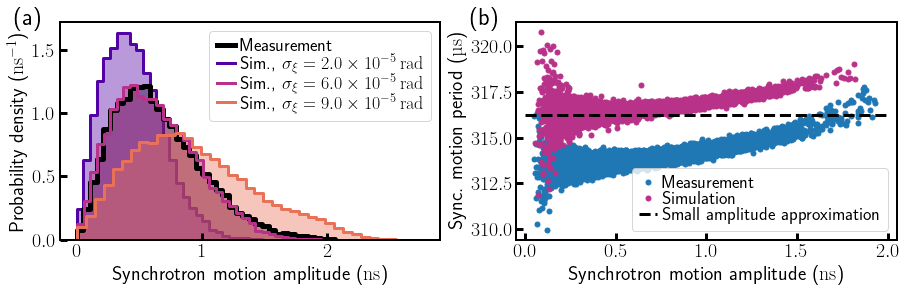

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))
ax0, ax1 = axs
for i, res in enumerate([rf_proj[j] for j in [2,6,9]]):
    rf_noise_std = res['rf_noise_std']
    rf_noise_label = res['rf_std_label']
    data = res['data']
    x = data['amplitude']['bin_centers']
    if i == 0:
        col="black"
        y = normalize(data['amplitude']['aggregated_hists']['meas'])/(x[1]-x[0])
        myhist(ax0, x, y, label="Measurement",
                linewidth=5, color=col, zorder=1)
    y = normalize(data['amplitude']['aggregated_hists']['sim'])/(x[1]-x[0])
    col = cols[i]
    myhist(ax0, x, y, label=r"Sim., $\sigma_\xi=\SI{"+rf_noise_label+"}{rad}$",
           color=col, zorder=i,
           linewidth=3)
ax0.set_ylabel(r"Probability density (\SI{}{ns}$^{-1}$)")
ax0.set_xlabel(r"Synchrotron motion amplitude (\SI{}{ns})")
# ax0.text(0.95, 0.45, r"SPAD TTS = \SI{"+f"{fit_tts}"+"}{ns}",
#          transform=ax0.transAxes,
#          va='bottom', ha='right')
ax0.set_ylim(0, ax0.get_ylim()[1])
ax0.legend()

ax1.plot(meas['amps'], 1e6*meas['pers'], '.', label='Measurement')
ax1.plot(sim['amps'], 1e6*sim['pers'], '.', color=purple, label='Simulation')
ax1.plot(np.array([0,2]),1e6*Ts*np.ones(2), color='black', linestyle='--', label="Small amplitude approximation")
ax1.set_xlim(-0.05, 2.05)
ax1.set_ylabel(r"Sync. motion period (\SI{}{\micro s})")
ax1.set_xlabel(r"Synchrotron motion amplitude (\SI{}{ns})")
ax1.legend(loc="lower right")


for ax, lab in zip(axs, ["(a)", "(b)"]):
    ax.text(-0.12, 1.07, lab, transform=ax.transAxes, va='top', ha='left',
           fontsize=24)

# fig.subplots_adjust(hspace=1000)

fig.savefig(os.path.join(images_dir,
                             "rf_jitter_and_per_vs_amp.png"),
            dpi=300, bbox_inches='tight')

plt.show()

(-5.5, 5.5, -0.04993235865858181, 1.0486615182000039)

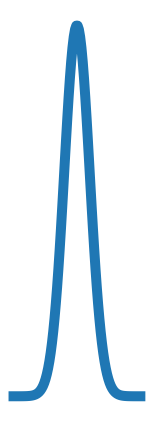

In [16]:
fig, ax = plt.subplots(figsize=(2.5, 7.5))
x = np.linspace(-5, 5, 100)
ax.plot(x, np.exp(-x**2/2), linewidth=10)
plt.axis('off')

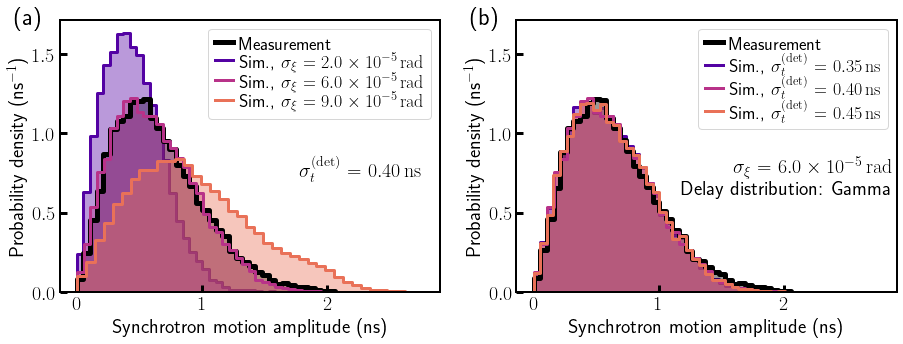

In [27]:
from ursse.path_assistant import get_plot_style_sheet
plt.style.use(get_plot_style_sheet("jinst"))
plt.rc('text.latex', preamble=
       r'\usepackage{siunitx}')
tts_latex = r"$\sigma^{\mathrm{(det)}}_t$"
fit_tts = 0.4
rf_proj = [r for r in all_results if (r['spad_tts'] == fit_tts) and (r['spad_tts_dist'] == 'Gamma')]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
ax0, ax1 = axs

colormap = cm.get_cmap("plasma")
cols = [colormap(i/14) for i in [2,6,9]]
alpha = 0.4
subtitlepos = 0.95, 0.5


for i, res in enumerate([rf_proj[j] for j in [2,6,9]]):
    rf_noise_std = res['rf_noise_std']
    rf_noise_label = res['rf_std_label']
    data = res['data']
    x = data['amplitude']['bin_centers']
    if i == 0:
        col="black"
        y = normalize(data['amplitude']['aggregated_hists']['meas'])/(x[1]-x[0])
        myhist(ax0, x, y, label="Measurement",
                linewidth=5, color=col, zorder=1)
    y = normalize(data['amplitude']['aggregated_hists']['sim'])/(x[1]-x[0])
    col = cols[i]
    myhist(ax0, x, y, label=r"Sim., $\sigma_\xi$ = "+r"\SI{"+rf_noise_label+"}{rad}",
           color=col, zorder=i,
           linewidth=3)
ax0.set_ylabel("Probability density (ns$^{-1}$)")
ax0.set_xlabel("Synchrotron motion amplitude (ns)")
ax0.text(*subtitlepos, tts_latex+r" = $\SI{0.40}{ns}$",
         transform=ax0.transAxes,
         va='top', ha='right')
ax0.set_ylim(0, ax0.get_ylim()[1])
ax0.legend()


fit_tts = 0.4
best_rf_label = "6.0e-05"
tts_proj = [r for r in all_results if (r['rf_std_label'] == best_rf_label)
            and (r['spad_tts_dist'] == 'Gamma')]

colormap = cm.get_cmap("plasma")
cols = [colormap(i/14) for i in [2, 6, 9]]
alpha = 0.4
subtitlepos = 0.99, 0.5


for i, res in enumerate([tts_proj[j] for j in [0, 1, 2]]):
    tts = res['spad_tts']
    data = res['data']
    x = data['amplitude']['bin_centers']
    if i == 0:
        col = "black"
        y = normalize(data['amplitude']['aggregated_hists']
                      ['meas'])/(x[1]-x[0])
        myhist(ax1, x, y, label="Measurement",
               linewidth=5, color=col, zorder=1)
    y = normalize(data['amplitude']['aggregated_hists']['sim'])/(x[1]-x[0])
    col = cols[i]
    myhist(ax1, x, y, label=f"Sim., "+tts_latex+r" = \SI{"+f"{tts:.2f}"+r"}{ns}",
           color=col, zorder=i,
           linewidth=3)
ax1.set_ylabel("Probability density (ns$^{-1}$)")
ax1.set_xlabel("Synchrotron motion amplitude (ns)")
ax1.text(*subtitlepos,
         r"$\sigma_\xi$ = $\SI{6.0e-5}{rad}$"
         + "\n" + f"Delay distribution: Gamma",
         transform=ax1.transAxes,
         va='top', ha='right')
ax1.set_ylim(0, ax0.get_ylim()[1])
ax1.set_xlim(ax0.get_xlim()[0], ax0.get_xlim()[1])
ax1.legend()


for ax, lab in zip(axs, ["(a)", "(b)"]):
    ax.text(-0.12, 1.05, lab, transform=ax.transAxes, va='top', ha='left',
           fontsize=24)

fig.savefig(os.path.join(images_dir,
                             "various_rf_jitter_std_jinst.png"),
            dpi=300, bbox_inches='tight')
plt.show()